In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import numpy as np
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$和偏差$b = 4.2$，以及一个随机噪声项$\epsilon$来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
test_examples = 100
true_w = [2, -3.4]
true_b = 4.2

# 训练集
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
# 测试集
features_test = nd.random.normal(scale=1, shape=(test_examples, num_inputs))
labels_test = true_w[0] * features_test[:, 0] + true_w[1] * features_test[:, 1] + true_b
labels_test += nd.random.normal(scale=0.01, shape=labels_test.shape)

通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

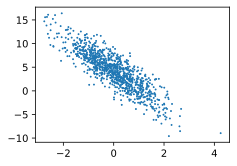

In [3]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

我们将上面的`plt`作图函数以及`use_svg_display`函数和`set_figsize`函数定义在`d2lzh`包里。以后在作图时，我们将直接调用`d2lzh.plt`。由于`plt`在`d2lzh`包中是一个全局变量，我们在作图前只需要调用`d2lzh.set_figsize()`即可打印矢量图并设置图的尺寸。


## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-1.1802915   0.37313533]
 [-0.9568079  -0.6704501 ]
 [ 0.46851125  0.81799334]
 [-0.9979552   0.17728648]
 [-0.34968698 -0.00564883]
 [-1.1250279  -0.46906072]
 [-0.02302936  1.7881038 ]
 [-0.8062988  -1.1381161 ]
 [-2.238252   -0.34891927]
 [ 0.42972964 -0.8840267 ]]
<NDArray 10x2 @cpu(0)> 
[ 0.55080545  4.5762944   2.3493972   1.5751895   3.5136492   3.540985
 -1.9272817   6.457418    0.9150594   8.061061  ]
<NDArray 10 @cpu(0)>


## 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [6]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度。

In [7]:
w.attach_grad()
b.attach_grad()

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`dot`函数做矩阵乘法。

In [8]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

## 定义损失函数

使用`MSE`损失函数

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

以下的`sgd`函数小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [10]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。由于变量`l`并不是一个标量，运行`l.backward()`将对`l`中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。

In [11]:
# 如果需要多次运行该cell，需要重新从初始化模型参数开始运行，否则将会从上一次运行得到的参数开始迭代
lr = 0.02
num_epochs = 100
net = linreg
loss = squared_loss
loss_set = np.zeros(num_epochs)

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    loss_set[epoch] = train_l.mean().asnumpy()
    # print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

## 绘制训练损失曲线和测试误差曲线

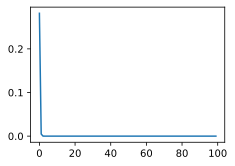

In [12]:
# 绘制训练损失曲线
plt.plot(np.array(range(num_epochs)), loss_set);

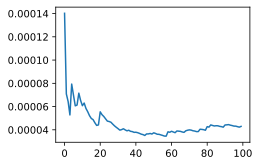

In [13]:
# 绘制测试误差曲线
test_err = np.zeros(test_examples)
for epoch in range(test_examples):
    test_l = loss(net(features_test[:epoch+1, :], w, b), labels_test[:epoch+1])
    test_err[epoch] = test_l.mean().asnumpy()
plt.plot(np.array(range(test_examples)), test_err);

In [14]:
true_w, w

([2, -3.4], 
 [[ 1.999931 ]
  [-3.4001102]]
 <NDArray 2x1 @cpu(0)>)

In [15]:
true_b, b

(4.2, 
 [4.200354]
 <NDArray 1 @cpu(0)>)